# Analyze SARS-CoV-2 3D Protein Structures
[Work in progress]

This notebook analyzes available 3D protein structures for the SAR-CoV-2 virus in the [Protein Data Bank](https://www.wwpdb.org/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Community Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

### Number of PDB Structures by Protein

In [4]:
reference_genome = 'refseq:NC_045512' # Genbank reference sequence
taxonomy_id = 'taxonomy:2697049' # SARS-CoV-2 taxonomy id

In [5]:
query = """
MATCH (p:Protein{taxonomyId:$taxonomy_id})-[t:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE t.coverage > 0.2 // exclude polyproteins
RETURN p.name AS protein, p.accession AS accession, p.proId AS uniprotChain, count(s) AS structures
ORDER BY accession
"""
pdbs = graph.run(query, reference_genome=reference_genome, taxonomy_id=taxonomy_id).to_data_frame()
pdbs.head(1000)

,protein,accession,uniprotChain,structures
0,Spike glycoprotein,uniprot:P0DTC2,None,215
1,Spike glycoprotein,uniprot:P0DTC2,uniprot.chain:PRO_0000449646,215
2,Spike protein S1,uniprot:P0DTC2,uniprot.chain:PRO_0000449647,67
3,Spike protein S2,uniprot:P0DTC2,uniprot.chain:PRO_0000449648,3
4,Spike protein S2',uniprot:P0DTC2,uniprot.chain:PRO_0000449649,6
5,ORF3a protein,uniprot:P0DTC3,uniprot.chain:PRO_0000449650,2
6,Envelope small membrane protein,uniprot:P0DTC4,uniprot.chain:PRO_0000449651,5
7,ORF7a protein,uniprot:P0DTC7,None,1
8,ORF7a protein,uniprot:P0DTC7,uniprot.chain:PRO_0000449654,1
9,ORF8 protein,uniprot:P0DTC8,None,4


### Number of structures by protein and structure determination method

In [6]:
query = """
MATCH (p:Protein{taxonomyId:$taxonomy_id})-[t:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE t.coverage > 0.2 // exclude polyproteins
RETURN p.name AS protein, p.accession AS accession, p.proId AS uniprotChain, s.method AS method, count(s.method) AS structures
ORDER BY accession
"""
pdbs = graph.run(query, reference_genome=reference_genome, taxonomy_id=taxonomy_id).to_data_frame()
pdbs.head(1000)

,protein,accession,uniprotChain,method,structures
0,Spike glycoprotein,uniprot:P0DTC2,None,ELECTRON MICROSCOPY,215
1,Spike glycoprotein,uniprot:P0DTC2,uniprot.chain:PRO_0000449646,ELECTRON MICROSCOPY,215
2,Spike protein S1,uniprot:P0DTC2,uniprot.chain:PRO_0000449647,ELECTRON MICROSCOPY,23
3,Spike protein S1,uniprot:P0DTC2,uniprot.chain:PRO_0000449647,X-RAY DIFFRACTION,44
4,Spike protein S2,uniprot:P0DTC2,uniprot.chain:PRO_0000449648,ELECTRON MICROSCOPY,3
5,Spike protein S2',uniprot:P0DTC2,uniprot.chain:PRO_0000449649,X-RAY DIFFRACTION,6
6,ORF3a protein,uniprot:P0DTC3,uniprot.chain:PRO_0000449650,ELECTRON MICROSCOPY,2
7,Envelope small membrane protein,uniprot:P0DTC4,uniprot.chain:PRO_0000449651,SOLID-STATE NMR,5
8,ORF7a protein,uniprot:P0DTC7,None,X-RAY DIFFRACTION,1
9,ORF7a protein,uniprot:P0DTC7,uniprot.chain:PRO_0000449654,X-RAY DIFFRACTION,1


### Number of structures by protein and release date

In [7]:
query = """
MATCH (p:Protein{taxonomyId:$taxonomy_id})-[t:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE t.coverage > 0.2 // exclude polyproteins
RETURN p.name AS protein, s.releaseDate AS releaseDate, count(s.releaseDate) AS structures
ORDER BY protein, releaseDate
"""
pdbs_by_date = graph.run(query, reference_genome=reference_genome, taxonomy_id=taxonomy_id).to_data_frame()

In [8]:
pdbs_by_date['cummulativeStructures'] = pdbs_by_date.groupby(['protein'])['structures'].cumsum()

In [9]:
pdbs_by_date.head()

,protein,releaseDate,structures,cummulativeStructures
0,2'-O-methyltransferase,2020-03-18,1,1
1,2'-O-methyltransferase,2020-03-25,2,3
2,2'-O-methyltransferase,2020-04-22,2,5
3,2'-O-methyltransferase,2020-04-29,2,7
4,2'-O-methyltransferase,2020-05-06,2,9


In [10]:
df_date = pd.DataFrame(pdbs_by_date.pivot(index='releaseDate', columns='protein', values='cummulativeStructures').to_records())

Convert neo4j date object to datetime

In [11]:
df_date['releaseDate'] = df_date['releaseDate'].astype(str)
df_date['releaseDate'] = pd.to_datetime(df_date['releaseDate'], infer_datetime_format=False) 

Fill gaps by value from previous day

In [12]:
df_date.fillna(method='ffill', inplace=True)
df_date['releaseDate'] = pd.to_datetime(df_date['releaseDate'], infer_datetime_format=False) 

In [13]:
df_date.head(1000)

,releaseDate,2'-O-methyltransferase,3C-like proteinase,Envelope small membrane protein,Helicase,Host translation inhibitor nsp1,Non-structural protein 10,Non-structural protein 7,Non-structural protein 8,Non-structural protein 9,Nucleoprotein,ORF3a protein,ORF7a protein,ORF8 protein,ORF9b protein,RNA-directed RNA polymerase,Spike glycoprotein,Spike protein S1,Spike protein S2,Spike protein S2',Uridylate-specific endoribonuclease
0,2020-02-05,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-26,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,6.0,NaN
2,2020-03-04,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,6.0,2.0
3,2020-03-11,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,18.0,2.0,NaN,6.0,4.0
4,2020-03-18,1.0,14.0,NaN,NaN,NaN,1.0,NaN,NaN,2.0,8.0,NaN,NaN,NaN,NaN,NaN,18.0,4.0,NaN,6.0,4.0
5,2020-03-25,3.0,84.0,NaN,NaN,NaN,4.0,NaN,NaN,2.0,8.0,NaN,NaN,NaN,NaN,NaN,18.0,5.0,NaN,6.0,4.0
6,2020-04-01,3.0,85.0,NaN,NaN,NaN,4.0,1.0,2.0,2.0,8.0,NaN,NaN,NaN,NaN,1.0,18.0,5.0,NaN,6.0,4.0
7,2020-04-08,3.0,85.0,NaN,NaN,NaN,4.0,2.0,4.0,3.0,9.0,NaN,NaN,NaN,NaN,2.0,18.0,5.0,NaN,6.0,4.0
8,2020-04-15,3.0,106.0,NaN,NaN,NaN,4.0,2.0,4.0,3.0,9.0,NaN,NaN,NaN,NaN,2.0,18.0,7.0,NaN,6.0,4.0
9,2020-04-22,5.0,107.0,NaN,NaN,NaN,6.0,5.0,8.0,3.0,15.0,NaN,NaN,NaN,NaN,4.0,18.0,7.0,NaN,6.0,4.0


In [14]:
# TODO use a better color scheme and line styles

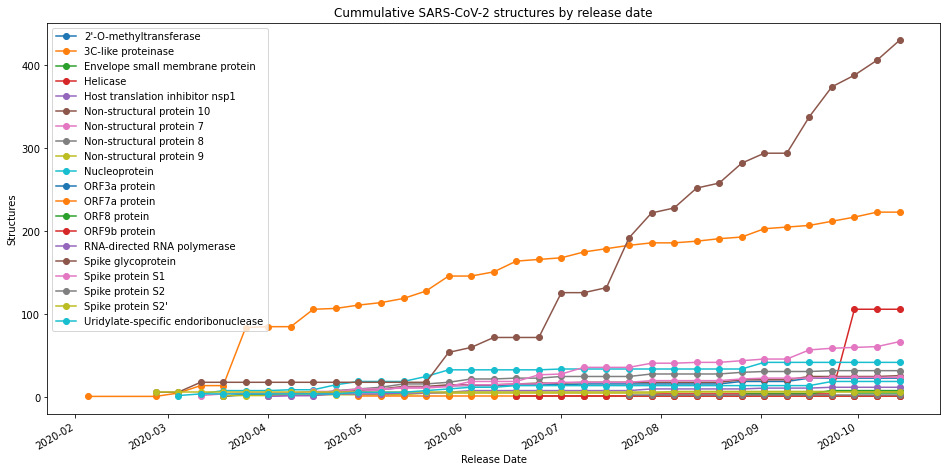

In [15]:
ax = df_date.plot(figsize=(16, 8), x='releaseDate', title='Cummulative SARS-CoV-2 structures by release date', marker='o');
ax.set_xlabel('Release Date');
ax.set_ylabel('Structures');
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

### Distribution of resolution by protein

In [16]:
query = """
MATCH (p:Protein{taxonomyId:$taxonomy_id})-[t:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE t.coverage > 0.2 AND s.method IN ['X-RAY DIFFRACTION', 'ELECTRON MICROSCOPY'] 
RETURN p.name AS protein, s.resolution AS resolution, s.name, s.method
ORDER BY protein, resolution
"""
pdbs_by_res = graph.run(query, reference_genome=reference_genome, taxonomy_id=taxonomy_id).to_data_frame()

In [17]:
df_res = pd.DataFrame(pdbs_by_res.pivot(columns='protein', values='resolution').to_records())

In [18]:
df_res.drop_duplicates(inplace=True)

In [19]:
df_res.drop('index', axis=1, inplace=True)

//miniconda3/envs/covid-19-community/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
//miniconda3/envs/covid-19-community/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 19.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


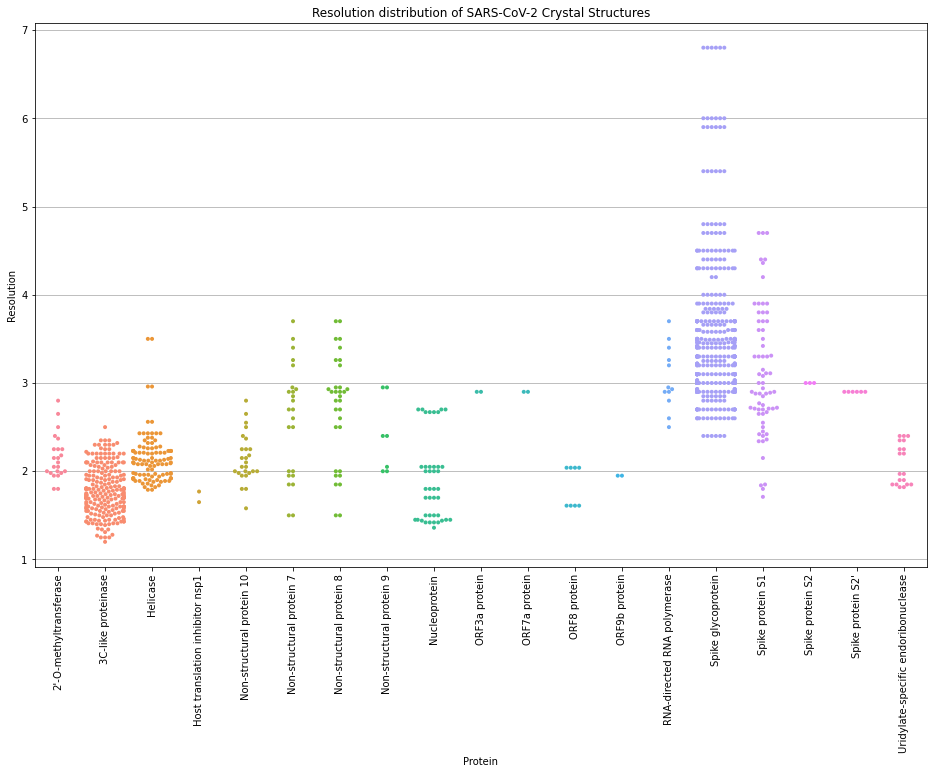

In [20]:
fig, axes = plt.subplots(figsize=(16, 10))
#sns.violinplot(data=df_res, scale='width', ax = axes)
sns.swarmplot(data=df_res, size=4, ax = axes)


axes.set_title('Resolution distribution of SARS-CoV-2 Crystal Structures')
axes.yaxis.grid(True)
axes.set_xlabel('Protein')
axes.set_ylabel('Resolution')

plt.xticks(rotation=90)
plt.show()